In [1]:
# SMOTE 적용
# 원핫인코딩 적용 안함
# Y transform 안함
# 결과가 나오는데 반올림하면 전부 유지 그래서 원핫 인코딩을 하는 게 좋을 것 같다.

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
# 엑셀 파일을 읽어옴
data = pd.read_excel('./modeling_data/2weeks_summary3.xlsx')

# MinMaxScaler()로 정규화
scaler = MinMaxScaler()
data[['Height', 'Weight', 'Step', 'Burn', 'Eat', 'Sleep']] = scaler.fit_transform(data[['Height', 'Weight', 'Step', 'Burn', 'Eat', 'Sleep']])


# Y_real 에는 마지막 원래 라벨값 넣어둠 -> 예측된 값과 비교하기 위해 쓰임
Y_real = data[['Label']]
Y_real = Y_real.to_numpy()

# 이유는 모르겠는데 라벨 타입을 인트로 바꿈 (에러 해결하기 위해 이랬음)
X = data[['Height','Weight','Step','Burn','Eat','Sleep']].values
data = data.astype({'Label':'int'})
Y = data[['Label']].values

In [3]:
input_size = 6        # input_size, 입력 변수의 개수
print(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# seq_length 만큼 데이터를 묶어주는 함수임
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

6


In [4]:
#split = 1600           # split 개수 만큼 train이 된다
split = int(0.7 * len(X))
epochs = 500
sequence_length = 6    # 함께 묵을 날짜 수
batch_size =6
# seq_data() 함수를 통해 데이터를 묶은 후 각각 x_seq, y_seq에 넣어 줌
x_seq, y_seq = seq_data(X, Y, sequence_length)


# train / test로 쪼갬
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

# SMOTE 사용하기 위해 차원을 바꿔 줌
nsamples, nx, ny = x_train_seq.shape
# print("nsamples :", nsamples)
# print("nx :", nx)
# print("ny :", ny)

x_train_seq = x_train_seq.reshape((nsamples, nx*ny))

#y_smote = torch.Tensor(pd.get_dummies(y_smote).values)
y_test_seq = y_test_seq.flatten()
y_test_seq = torch.Tensor(pd.get_dummies(y_test_seq).values)
#y_test_seq = y_test_seq.tolist()
#y_test_seq = torch.Tensor(pd.get_dummies(y_test_seq).values)
print('The shape of test_y: {} \n'.format(y_test_seq.shape))    # train만 SMOTE 적용 (y)

#test_y 원핫인코딩 확인용
#print(y_test_seq)


# SOMTE 적용 전 shape 확인용
print('Before SMOTE OverSampling, the shape of x: {}'.format(x_seq.shape))
print('Before SMOTE OverSampling, the shape of y: {} \n'.format(y_seq.shape))

# SMOTE 기법 사용하여 train 늘려 줌
sm = SMOTE(random_state=0)
x_smote, y_smote = sm.fit_resample(x_train_seq, y_train_seq)

# SMOTE 적용 후 shape 확인용
print('After SMOTE OverSampling, the shape of x: {}'.format(x_smote.shape))       # train만 SMOTE 적용 (x)
print('After SMOTE OverSampling, the shape of y: {} \n'.format(y_smote.shape))    # train만 SMOTE 적용 (y)

x_smote = torch.Tensor(x_smote)
tempx, tempx2  = x_smote.shape
x_smote = x_smote.reshape((tempx, sequence_length, input_size))

y_smote = torch.Tensor(pd.get_dummies(y_smote).values)
#print(y_smote)
#tempy, = y_smote.shape
#y_smote = y_smote.reshape((tempy, 1))

print('After SMOTE OverSampling, the shape of x: {}'.format(x_smote.shape))       # train만 SMOTE 적용 (x)
print('After SMOTE OverSampling, the shape of y: {} \n'.format(y_smote.shape))    # train만 SMOTE 적용 (y)

#y_smote= pd.get_dummies(y_smote)
#print(y_smote)

####################################
# Before SMOTE OverSampling, the shape of x: torch.Size([1926, 6, 6])
# Before SMOTE OverSampling, the shape of y: torch.Size([1926, 1]
# After SMOTE OverSampling, the shape of x: torch.Size([4347, 6, 6])
# After SMOTE OverSampling, the shape of y: torch.Size([4347, 3])

The shape of test_y: torch.Size([574, 3]) 

Before SMOTE OverSampling, the shape of x: torch.Size([1926, 6, 6])
Before SMOTE OverSampling, the shape of y: torch.Size([1926, 1]) 

After SMOTE OverSampling, the shape of x: (3672, 36)
After SMOTE OverSampling, the shape of y: (3672,) 

After SMOTE OverSampling, the shape of x: torch.Size([3672, 6, 6])
After SMOTE OverSampling, the shape of y: torch.Size([3672, 3]) 



C:\Users\Lab01\AppData\Local\Temp\ipykernel_3328\2444376344.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)


In [5]:
# TensorDataset에 넣어줌
train = torch.utils.data.TensorDataset(x_smote, y_smote)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)


# 길이 확인용 train은 smote 한 후 길이가 늘어나 있고
# test는 smote를 적용안해서 전체 길이 - seq_length가 들어가 있음
# print("len(train): ", len(train))
# print("len(test): ", len(test))

##################################
#len(train):  4347
#len(test):  326

In [6]:
# trainloader 와 testloader에 각각 train과 test셋을 넣어 줌
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=6, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=6)

In [7]:
#print(len(trainloader.dataset))

num_layers = 1  # lstm 층의 수, Number of recurrent layers
# setting num_layers=2 would mean stacking two LSTMs together to form stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results
hidden_size = 6  # 은닉층의 피처 개수
num_classes = 3  # number of output classes

class LSTM(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.input_size = input_size  # input size
        self.num_classes = num_classes  # number of classes
        self.hidden_size = hidden_size  # hidden state
        self.sequence_length = sequence_length  # sequence length
        self.num_layers = num_layers  # number of layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        c_0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first Dense
        out = self.relu(out)  # relu
        out = self.fc(out)  # Final Output
        out = self.softmax(out)
        return out

In [8]:
# 모델 정의
model = LSTM(input_size=input_size, num_classes=num_classes, hidden_size=hidden_size, num_layers=num_layers,
             sequence_length=sequence_length, device=device).to(device)

criterion = nn.MSELoss()  # MSE 손실함수 사용
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer 사용

In [9]:
n = len(trainloader)    # n에 trainloader 길이 넣어 줌
loss_graph = []         # 손실값 구하는 데 사용할 배열
accuracy_graph = []

# epoch 만큼 반복하며 loss 구하며 최적화
for epoch in range(epochs):
    running_loss = 0.0
    corr = 0.0
    for data in trainloader:
        seq, target = data
#         print(seq.shape)  #6*6*3
#         print(target.shape)   #6*3
        outputs = model(seq)   # model.forward()랑 그냥이랑 무슨차이 -> 그냥 model이 더 좋은듯
        optimizer.zero_grad()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        out = model(seq)
#         out=out.detach().numpy()
#         print(type(out))
       
#         target=target.detach().numpy()
#         print(target)
#         print(out)

        target = torch.argmax(target, dim=1)
        out = torch.argmax(out, dim=1)
#         print("1",target)
#         print("2",out)
        
        corr += (target == out).sum()/3600
        
        
    #if epoch % 100 == 0:
    print("Epoch : %d loss : %.4f, accuracy :  "  ,(epoch, running_loss / n,corr.item() ))
    accuracy_graph.append(corr.item())
    loss_graph.append(running_loss / n)
    
concatdata = torch.utils.data.ConcatDataset([test])
data_loader = torch.utils.data.DataLoader(concatdata)

Epoch : %d loss : %.4f, accuracy :   (0, 0.21771999928199387, 0.4127774238586426)
Epoch : %d loss : %.4f, accuracy :   (1, 0.2127135843769008, 0.43555524945259094)
Epoch : %d loss : %.4f, accuracy :   (2, 0.21084885642516846, 0.4502773880958557)
Epoch : %d loss : %.4f, accuracy :   (3, 0.2066177043309009, 0.4780552089214325)
Epoch : %d loss : %.4f, accuracy :   (4, 0.2007147090180832, 0.519999623298645)
Epoch : %d loss : %.4f, accuracy :   (5, 0.19710022044288955, 0.5316663980484009)
Epoch : %d loss : %.4f, accuracy :   (6, 0.1924315105661068, 0.5541661381721497)
Epoch : %d loss : %.4f, accuracy :   (7, 0.1868717919645551, 0.5838884711265564)
Epoch : %d loss : %.4f, accuracy :   (8, 0.18015409230552856, 0.5919439792633057)
Epoch : %d loss : %.4f, accuracy :   (9, 0.175578473056697, 0.6066664457321167)
Epoch : %d loss : %.4f, accuracy :   (10, 0.1709906698928939, 0.6199995279312134)
Epoch : %d loss : %.4f, accuracy :   (11, 0.16769567803400598, 0.6377770900726318)
Epoch : %d loss : %.4f

Epoch : %d loss : %.4f, accuracy :   (100, 0.09295667622586883, 0.847777247428894)
Epoch : %d loss : %.4f, accuracy :   (101, 0.09314009091692058, 0.8450002074241638)
Epoch : %d loss : %.4f, accuracy :   (102, 0.09173372059773648, 0.8469445705413818)
Epoch : %d loss : %.4f, accuracy :   (103, 0.0908331903691778, 0.8497223258018494)
Epoch : %d loss : %.4f, accuracy :   (104, 0.09142977171737299, 0.8519445657730103)
Epoch : %d loss : %.4f, accuracy :   (105, 0.09104652696797393, 0.8494443893432617)
Epoch : %d loss : %.4f, accuracy :   (106, 0.090652142727848, 0.8483333587646484)
Epoch : %d loss : %.4f, accuracy :   (107, 0.09019996486493885, 0.8505555391311646)
Epoch : %d loss : %.4f, accuracy :   (108, 0.08890373420747898, 0.8541671633720398)
Epoch : %d loss : %.4f, accuracy :   (109, 0.08923141672534661, 0.8516669273376465)
Epoch : %d loss : %.4f, accuracy :   (110, 0.08833608086322879, 0.8580557703971863)
Epoch : %d loss : %.4f, accuracy :   (111, 0.08871290316345669, 0.85083335638046

Epoch : %d loss : %.4f, accuracy :   (199, 0.06859247074782995, 0.891944944858551)
Epoch : %d loss : %.4f, accuracy :   (200, 0.06760881954553304, 0.8950001001358032)
Epoch : %d loss : %.4f, accuracy :   (201, 0.0674709978486218, 0.8963895440101624)
Epoch : %d loss : %.4f, accuracy :   (202, 0.0671441342682217, 0.8966671228408813)
Epoch : %d loss : %.4f, accuracy :   (203, 0.06870974605993194, 0.892500102519989)
Epoch : %d loss : %.4f, accuracy :   (204, 0.06771566357196908, 0.8961114287376404)
Epoch : %d loss : %.4f, accuracy :   (205, 0.06755177004876173, 0.8983336091041565)
Epoch : %d loss : %.4f, accuracy :   (206, 0.06751690731789792, 0.8963891863822937)
Epoch : %d loss : %.4f, accuracy :   (207, 0.06713527202982078, 0.8975005745887756)
Epoch : %d loss : %.4f, accuracy :   (208, 0.06776026721790378, 0.8936116099357605)
Epoch : %d loss : %.4f, accuracy :   (209, 0.06663334316397512, 0.8983337879180908)
Epoch : %d loss : %.4f, accuracy :   (210, 0.06691459389782002, 0.89888954162597

Epoch : %d loss : %.4f, accuracy :   (297, 0.057824929354776, 0.918611466884613)
Epoch : %d loss : %.4f, accuracy :   (298, 0.05744198119092152, 0.9172224998474121)
Epoch : %d loss : %.4f, accuracy :   (299, 0.05643114564009011, 0.9258338212966919)
Epoch : %d loss : %.4f, accuracy :   (300, 0.05661460855670014, 0.9230558276176453)
Epoch : %d loss : %.4f, accuracy :   (301, 0.05849645734949911, 0.9205558896064758)
Epoch : %d loss : %.4f, accuracy :   (302, 0.05668394496996626, 0.9205556511878967)
Epoch : %d loss : %.4f, accuracy :   (303, 0.05731621351441349, 0.9191672205924988)
Epoch : %d loss : %.4f, accuracy :   (304, 0.05584579008199416, 0.9222227931022644)
Epoch : %d loss : %.4f, accuracy :   (305, 0.05533336565853686, 0.9244449734687805)
Epoch : %d loss : %.4f, accuracy :   (306, 0.05583112908491969, 0.9219449758529663)
Epoch : %d loss : %.4f, accuracy :   (307, 0.05534800231679006, 0.9211113452911377)
Epoch : %d loss : %.4f, accuracy :   (308, 0.0561418650548838, 0.91805565357208

Epoch : %d loss : %.4f, accuracy :   (395, 0.0499366956685178, 0.9336116909980774)
Epoch : %d loss : %.4f, accuracy :   (396, 0.048559709298347915, 0.9377781748771667)
Epoch : %d loss : %.4f, accuracy :   (397, 0.04810456562323107, 0.936389684677124)
Epoch : %d loss : %.4f, accuracy :   (398, 0.04976858590877182, 0.9338895678520203)
Epoch : %d loss : %.4f, accuracy :   (399, 0.049465619694410934, 0.9361117482185364)
Epoch : %d loss : %.4f, accuracy :   (400, 0.04907375408356232, 0.936944842338562)
Epoch : %d loss : %.4f, accuracy :   (401, 0.048648408993117565, 0.9363896250724792)
Epoch : %d loss : %.4f, accuracy :   (402, 0.04829422223692924, 0.9372226595878601)
Epoch : %d loss : %.4f, accuracy :   (403, 0.04849129856795556, 0.9363895058631897)
Epoch : %d loss : %.4f, accuracy :   (404, 0.04996941814311909, 0.9338890314102173)
Epoch : %d loss : %.4f, accuracy :   (405, 0.048541064850432795, 0.9358338117599487)
Epoch : %d loss : %.4f, accuracy :   (406, 0.0479049983343602, 0.9394449591

Epoch : %d loss : %.4f, accuracy :   (493, 0.04464944892215142, 0.9461115598678589)
Epoch : %d loss : %.4f, accuracy :   (494, 0.04345279351448994, 0.9436115026473999)
Epoch : %d loss : %.4f, accuracy :   (495, 0.044324234850987194, 0.9450005292892456)
Epoch : %d loss : %.4f, accuracy :   (496, 0.044902413031412625, 0.943611204624176)
Epoch : %d loss : %.4f, accuracy :   (497, 0.04345347720400137, 0.9449999332427979)
Epoch : %d loss : %.4f, accuracy :   (498, 0.04305579734414963, 0.9472224712371826)
Epoch : %d loss : %.4f, accuracy :   (499, 0.04518145512874564, 0.9447224140167236)


In [10]:
# https://076923.github.io/posts/Python-pytorch-9/ 참고하면 테스트 데이터 정의해서 모델 평가하는 것도 확인 가능 -> 입력과 차원을 같게
with torch.no_grad():   # gradient 옵션을 그만할 때 사용, 보통 더이상 학습 안하고 학습된 모델로 결과를 볼 때 사용
    pred = []
    model.eval()        # evaluation 과정에서 사용하지 않아도 되는 layer들을 off 시켜줌
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

print(pred)        
        
pred = torch.Tensor(pred)  #이유는 모르겠는데 pred가 list라 argmax 쓰기 위해 torch로 변환
# 변환 후 결과 확인(Tensor)

length = len(pred)
pred_result = torch.argmax(pred, dim=1)

# 0~2가 리턴, 라벨을 1~3으로해서 하나씩 더해야함
pred_result = pred_result.tolist()
print(pred_result)

#라벨링 결과 확인
print(pred_result)

count = 0


forTestLength = len(X)-sequence_length-split
#print("Num of Test : ", forTestLength)


for i in range(forTestLength):
     if pred_result[i] == Y_real[forTestLength+i][0]:
         count = count+1

ck1=0
ck2=0
ck3=0
for i in range(forTestLength):
     if Y_real[forTestLength+i][0]== 1:
         ck1 = ck1+1
     elif Y_real[forTestLength + i][0] == 2:
         ck2 = ck2 + 1
     elif Y_real[forTestLength + i][0] == 3:
         ck3 = ck3 + 1
#scattetX = [ x for x in range(forTestLength)]
print("ck1", ck1)
print("ck2", ck2)
print("ck3", ck3)

print(f1_score(Y[split+sequence_length:], pred_result[:], average='micro'))

#ax = plt.subplot()

[[0.5681285858154297, 0.14104431867599487, 0.2908271849155426], [0.8340463638305664, 0.015429997816681862, 0.15052366256713867], [0.9475976228713989, 0.003086569719016552, 0.049315743148326874], [0.8940355777740479, 0.00024264492094516754, 0.10572170466184616], [0.9922101497650146, 8.947736932896078e-05, 0.00770044419914484], [0.9999959468841553, 6.962453595939515e-16, 4.107829226995818e-06], [0.9998730421066284, 1.5049120349885925e-07, 0.00012683216482400894], [0.07983282208442688, 0.9197787046432495, 0.0003885074402205646], [0.7647671699523926, 0.22156313061714172, 0.01366973202675581], [0.8447627425193787, 0.08313990384340286, 0.07209745049476624], [0.8638013601303101, 0.1348419487476349, 0.0013567436253651977], [0.9885299801826477, 0.0018413502257317305, 0.00962860882282257], [1.0, 6.256455869567792e-16, 4.2462491856021245e-10], [1.0, 2.4352011945103923e-16, 2.288853967469251e-10], [1.0, 1.4950221516289047e-16, 1.3935394505004695e-10], [1.0, 2.6315802515609554e-19, 6.87924719901429

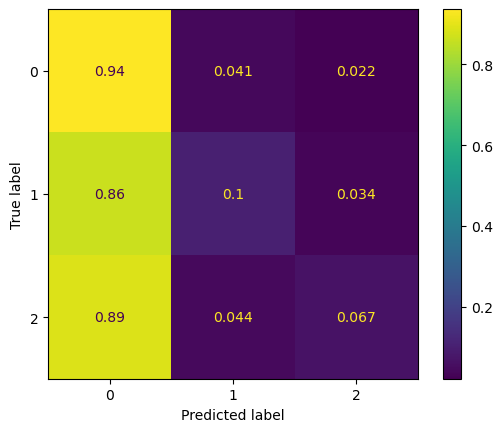

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(pred_result[:],Y[split+sequence_length:])
cm = confusion_matrix(pred_result[:],Y[split+sequence_length:], labels=[0,1,2], normalize="true")
# cm=cm / cm.astype(np.float).sum(axis=1)
# print(len(pred_result[:]))
# print(len(Y[split+sequence_length:]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()

plt.savefig('savefig_default.png')
plt.show()

In [12]:
#scattetX = [ x for x in range(forTestLength)]
#plt.figure(figsize=(20, 10))
#plt.title("BMI prediction")
#plt.scatter(scattetX, Y[split+sequence_length:],  c='r', label='real value')          # 빨간색이 실제
#plt.scatter(scattetX, pred_result[:], c='b', linewidth=0.6, label='prediction')             # 파란색이 예측

#plt.legend()                                                          # 범례 적용
#plt.show()

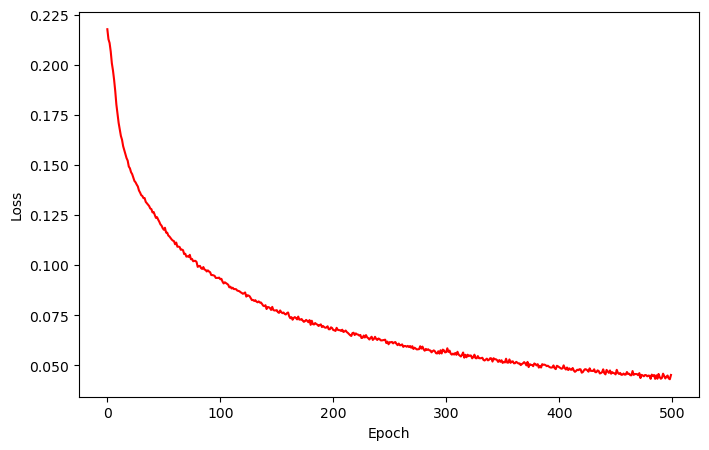

In [13]:
epochlist = [ x for x in range(len(loss_graph))]

loss_graph = np.array(loss_graph)
#loss_graph = np.reshape(1,-1)
# print(loss_graph)
# print(epochs)
# print(len(loss_graph))
plt.figure(figsize=(8,5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochlist, loss_graph, label='train loss', color='red')
plt.show()

# print("count : ", count, "length : ", forTestLength)
# print("Accuracy: ", count/forTestLength)

In [14]:
loss_graph.shape

(500,)

500


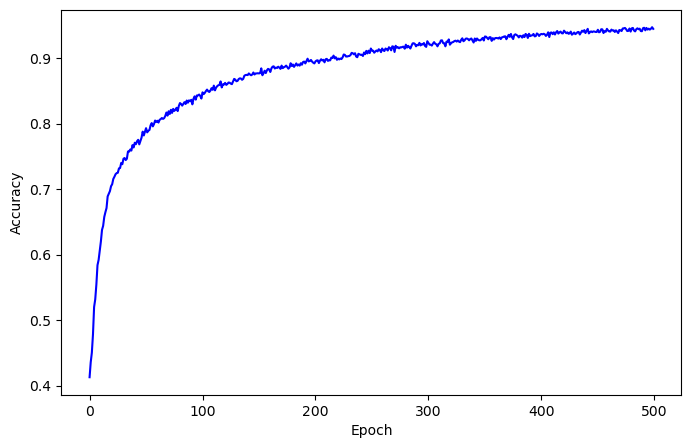

In [15]:
epochlist = [ x for x in range(len(accuracy_graph))]
print(len(epochlist))
accuracy_graph = np.array(accuracy_graph)
accuracy_graph=accuracy_graph.reshape(500,-1)
epochlist=np.array(epochlist)
epochlist=epochlist.reshape(500,-1)

plt.figure(figsize=(8,5))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(epochlist, accuracy_graph, label='train loss', color='blue')
plt.show()

In [16]:
print(f1_score(Y[split+sequence_length:], pred_result[:], average='micro'))

0.7003484320557491


In [17]:
print("Acc",count/forTestLength)

Acc 0.6724738675958188
